<a href="https://colab.research.google.com/github/sayakpaul/Consistency-Training-with-Supervision/blob/main/Consistency_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -q tf-models-official tensorflow-addons

     |████████████████████████████████| 1.1MB 7.1MB/s 
     |████████████████████████████████| 706kB 10.9MB/s 
     |████████████████████████████████| 1.2MB 24.2MB/s 
     |████████████████████████████████| 358kB 47.1MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 645kB 44.9MB/s 
     |████████████████████████████████| 37.6MB 154kB/s 
     |████████████████████████████████| 174kB 54.8MB/s 


In [2]:
from official.vision.image_classification.augment import RandAugment
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [3]:
try: 
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
  strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.108.115.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.115.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## Define Hyperparameters

In [4]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 100

CROP_TO = 72
RESIZE_TO = 96

## Load Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

val_samples = 49500
new_train_x, new_y_train = x_train[:val_samples+1], y_train[:val_samples+1]
val_x, val_y = x_train[val_samples:], y_train[val_samples:]

170500096/170498071 [==============================] - 2s 0us/step


## Prepare Data Loaders

In [6]:
augmenter = RandAugment(num_layers=2, magnitude=9)

In [7]:
def preprocess_train(image, label, noisy=True):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    if noisy:
        image = augmenter.distort(image)
    image = tf.reshape(image, [CROP_TO, CROP_TO, 3])
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, [CROP_TO, CROP_TO])
    image = tf.reshape(image, [CROP_TO, CROP_TO, 3])
    return image, label

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((new_train_x, new_y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [9]:
train_clean_ds = (train_ds
                  .shuffle(BATCH_SIZE*10, seed=42)
                  .repeat()  
                  .map(lambda x, y: (preprocess_train(x, y, noisy=False)), 
                       num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

train_noisy_ds = (train_ds
                  .shuffle(BATCH_SIZE*10, seed=42)
                  .repeat()  
                  .map(preprocess_train, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

validation_ds = (validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

test_ds = (test_ds.map(preprocess_test, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

## Visualize a few samples

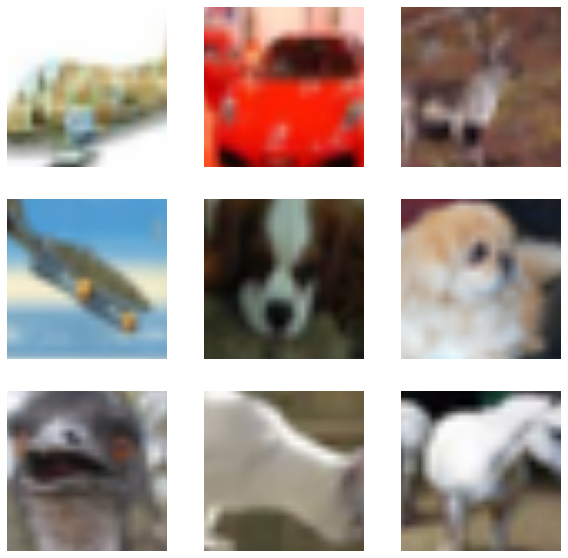

In [10]:
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

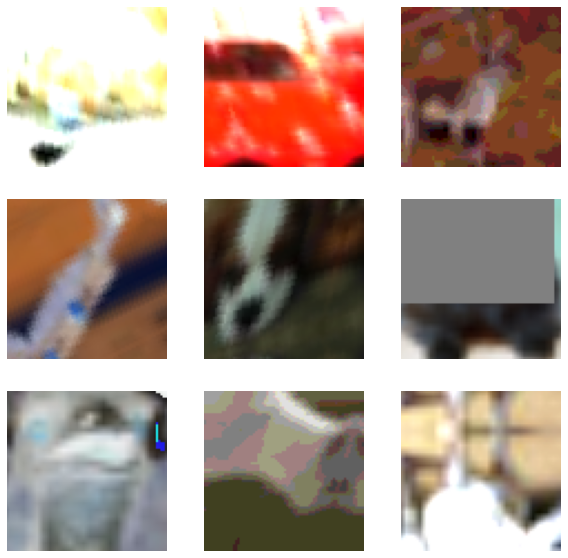

In [11]:
sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Model Building Utility

In [12]:
def get_training_model(num_classes=10):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=False,
        input_shape=(CROP_TO, CROP_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((CROP_TO, CROP_TO, 3)),
            layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes)
        ]
    )
    return model

## Train the teacher

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Either use SWA or MA to induce an ensembling effect
SWA = tfa.optimizers.SWA
MA = tfa.optimizers.MovingAverage

In [25]:
with strategy.scope():
    teacher_model = get_training_model()
    teacher_model.compile(optimizer=SWA(tf.keras.optimizers.Adam()),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

history = teacher_model.fit(
    train_clean_ds,
    steps_per_epoch=len(new_train_x)//BATCH_SIZE,
    epochs=EPOCHS,  
    validation_data=validation_ds,
    callbacks=[reduce_lr, es]
)

with strategy.scope():
    _, acc = teacher_model.evaluate(test_ds, verbose=0)
    print(f"Test accuracy: {acc*100}%")

Epoch 1/100
48/48 [==============================] - 137s 187ms/step - loss: 2.1880 - accuracy: 0.2775 - val_loss: 4.0903 - val_accuracy: 0.1180
Epoch 2/100
48/48 [==============================] - 5s 99ms/step - loss: 1.3920 - accuracy: 0.4953 - val_loss: 2.7935 - val_accuracy: 0.2060
Epoch 3/100
48/48 [==============================] - 5s 99ms/step - loss: 1.2117 - accuracy: 0.5696 - val_loss: 3.1153 - val_accuracy: 0.1940
Epoch 4/100
48/48 [==============================] - 5s 100ms/step - loss: 1.0737 - accuracy: 0.6197 - val_loss: 2.7424 - val_accuracy: 0.2720
Epoch 5/100
48/48 [==============================] - 5s 100ms/step - loss: 0.9552 - accuracy: 0.6635 - val_loss: 2.4496 - val_accuracy: 0.3800
Epoch 6/100
48/48 [==============================] - 5s 100ms/step - loss: 0.8542 - accuracy: 0.6997 - val_loss: 1.9726 - val_accuracy: 0.4480
Epoch 7/100
48/48 [==============================] - 5s 100ms/step - loss: 0.7754 - accuracy: 0.7279 - val_loss: 1.5089 - val_accuracy: 0.5700

## Self-training utility

In [15]:
# Majority of the code is taken from:
# https://keras.io/examples/vision/knowledge_distillation/
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds

        # Forward pass of teacher
        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(noisy_images, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            student_loss = tf.nn.compute_average_loss(student_loss, 
                                                           global_batch_size=BATCH_SIZE)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            distillation_loss = tf.nn.compute_average_loss(distillation_loss, 
                                                           global_batch_size=BATCH_SIZE)
            total_loss = (student_loss + distillation_loss) / 2
        
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`
        self.compiled_metrics.update_state(y, 
                                           tf.nn.softmax(student_predictions, axis=1))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"total_loss": total_loss}
        )
        return results

    def test_step(self, data):
        # During inference, we only pass a dataset consisting images and labels.
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        return results

## Train an equal-size student with consistency regularization

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor="val_accuracy")
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

with strategy.scope():
    distiller = Distiller(student=get_training_model(), teacher=teacher_model)
    distiller.compile(
        optimizer="adam",
        metrics=["accuracy"],
        student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE),
        distillation_loss_fn=tf.keras.losses.KLDivergence(
            reduction=tf.keras.losses.Reduction.NONE),
        temperature=10,
    )

history = distiller.fit(
    consistency_training_ds,
    steps_per_epoch=len(new_train_x)//BATCH_SIZE,
    epochs=EPOCHS,  
    validation_data=validation_ds,
    callbacks=[reduce_lr, es]
)

with strategy.scope():
    acc = distiller.evaluate(test_ds, verbose=0)
    print(f"Test accuracy from student model: {acc*100}%")

Epoch 1/100
48/48 [==============================] - 62s 206ms/step - accuracy: 0.1782 - total_loss: 0.1540 - val_accuracy: 0.0920
Epoch 2/100
48/48 [==============================] - 6s 119ms/step - accuracy: 0.2974 - total_loss: 0.1325 - val_accuracy: 0.1600
Epoch 3/100
48/48 [==============================] - 6s 120ms/step - accuracy: 0.3452 - total_loss: 0.1270 - val_accuracy: 0.2040
Epoch 4/100
48/48 [==============================] - 6s 120ms/step - accuracy: 0.3888 - total_loss: 0.1196 - val_accuracy: 0.2240
Epoch 5/100
48/48 [==============================] - 6s 121ms/step - accuracy: 0.4192 - total_loss: 0.1168 - val_accuracy: 0.3660
Epoch 6/100
48/48 [==============================] - 6s 121ms/step - accuracy: 0.4441 - total_loss: 0.1119 - val_accuracy: 0.3960
Epoch 7/100
48/48 [==============================] - 6s 122ms/step - accuracy: 0.4713 - total_loss: 0.1076 - val_accuracy: 0.4520
Epoch 8/100
48/48 [==============================] - 6s 121ms/step - accuracy: 0.4885 - t

## Serialization

In [27]:
distiller.student.save_weights("student_noisy_swa.h5")
teacher_model.save_weights("teacher_model_swa.h5")

In [28]:
!mkdir /content/drive/MyDrive/consistency_training
!cp -r *_swa.h5 /content/drive/MyDrive/consistency_training